<a href="https://colab.research.google.com/github/Marteldelfer/PISI3/blob/main/Clustering_e_algoritmo_de_recomenda%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando dependências

In [ ]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import ast
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Carregando Dataset

In [ ]:
df = pd.read_csv('tmdb_clean.csv')

# Pré-processamento

Exclua o atributo id

In [ ]:

df = df.drop('id', axis=1)
df.columns


Index(['title', 'vote_average', 'vote_count', 'release_date', 'revenue',
       'runtime', 'budget', 'original_language', 'popularity', 'genres',
       'production_companies', 'production_countries', 'cast', 'director',
       'director_of_photography', 'writers', 'producers', 'music_composer',
       'imdb_rating', 'imdb_votes'],
      dtype='object')

# Numerização dos atributos categóricos usando matrizes esparsas





In [ ]:
!mkdir "matrizes_esparsas"

In [ ]:
from scipy.sparse import save_npz
from scipy.sparse import csr_matrix
from collections import Counter


def str_para_categorico(df: pd.DataFrame, coluna: str, k: int) -> pd.DataFrame:
    """
    Converte atributo de string para matriz esparsa
    """
    c = Counter()
    for string in df[coluna]:
        if string is not np.nan:
            c.update(string.split(", "))
    res = pd.DataFrame(index=df["title"])

    n_cols = 0
    for i in c.most_common():
        n_cols += 1
        if i[1] < k:
            break
    print(coluna, n_cols, "colunas")

    for i in c.most_common():
        if i[1] < k:
            break
        nova_col = []
        for string in df[coluna]:
            if string is not np.nan:
                nova_col.append(1 if i[0] in string.split(", ") else 0)
            else:
                nova_col.append(0)
        res[i[0]] = np.array(nova_col, dtype=np.int8)
        res = res.copy()

    sparse = csr_matrix(res)
    save_npz(f"matrizes_esparsas/sparse_{coluna}_{k}.npz", sparse) # Salva em forma de matriz esparsa scipy

    return res

In [ ]:
for col in ["genres", "writers", "director", "director_of_photography", "music_composer", "cast", "production_countries", "original_language", "producers", "production_companies"]:
    try:
        str_para_categorico(df, col, 25)
    except:
        print(col)

genres 19 colunas
writers 13 colunas
director 9 colunas
director_of_photography 46 colunas
music_composer 68 colunas
cast 751 colunas
production_countries 48 colunas
original_language 28 colunas
producers 162 colunas
production_companies 151 colunas


In [ ]:
from scipy.sparse import load_npz
from scipy.sparse import hstack
import os

def abrir_matrizes_esparsas(k: int = 5):
    """
    Carrega e concatena matrizes esparsas
    """
    l = []
    for arquivo in os.listdir("./matrizes_esparsas"):
        try:
            k_ok = int(arquivo.split("_")[-1][:-4]) == k
        except:
            k_ok = False
        if arquivo[-4:] == ".npz" and k_ok:
            l.append(load_npz(f"./matrizes_esparsas/{arquivo}"))
            print(arquivo)
    return hstack(l)

In [ ]:
sparse = abrir_matrizes_esparsas(25)


sparse_production_companies_25.npz
sparse_genres_25.npz
sparse_writers_25.npz
sparse_original_language_25.npz
sparse_director_25.npz
sparse_producers_25.npz
sparse_director_of_photography_25.npz
sparse_music_composer_25.npz
sparse_production_countries_25.npz
sparse_cast_25.npz


# Teste - Usando método do cotovelo para determinar o número ideal de clusters

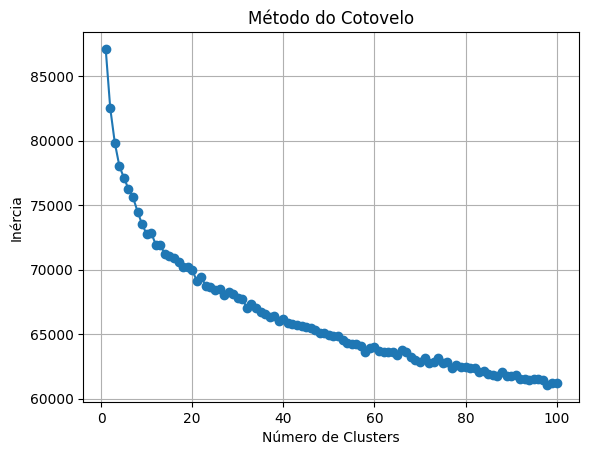

In [ ]:
inertia = []
max_clusters = 100  # Defina um número máximo razoável de clusters para testar

# Substitua 'encoded_df' por 'sua_matriz_binarizada' ou a matriz que você quer usar
# para o clustering, que pode ser esparsa.
data_for_clustering = sparse # Use encoded_df ou sua matriz binarizada/esparsa aqui

# Testando diferentes números de clusters
for i in range(1, max_clusters + 1):
    # KMeans funciona com matrizes esparsas
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10) # Adicionado n_init
    kmeans.fit(data_for_clustering)
    inertia.append(kmeans.inertia_)

plt.plot(range(1, max_clusters + 1), inertia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de Clusters')
plt.ylabel('Inércia')
plt.grid(True)
plt.show()


# Teste -Usando o método da silhueta para determinar o número idea de clusters

Para n_clusters = 2, o score médio da silhueta é: 0.03633082105214425
Para n_clusters = 3, o score médio da silhueta é: 0.039139148612439764
Para n_clusters = 4, o score médio da silhueta é: 0.04592956631674064
Para n_clusters = 5, o score médio da silhueta é: 0.029618227864062277
Para n_clusters = 6, o score médio da silhueta é: 0.012609324232669944
Para n_clusters = 7, o score médio da silhueta é: 0.003150756408837078
Para n_clusters = 8, o score médio da silhueta é: 0.04668087486845328
Para n_clusters = 9, o score médio da silhueta é: 0.023991590926099482
Para n_clusters = 10, o score médio da silhueta é: 0.015295371072337225
Para n_clusters = 11, o score médio da silhueta é: 0.02040340217201219
Para n_clusters = 12, o score médio da silhueta é: 0.018614143654724212
Para n_clusters = 13, o score médio da silhueta é: 0.010704288356773416
Para n_clusters = 14, o score médio da silhueta é: 0.0187130260259559
Para n_clusters = 15, o score médio da silhueta é: -0.01622426371563915
Para n

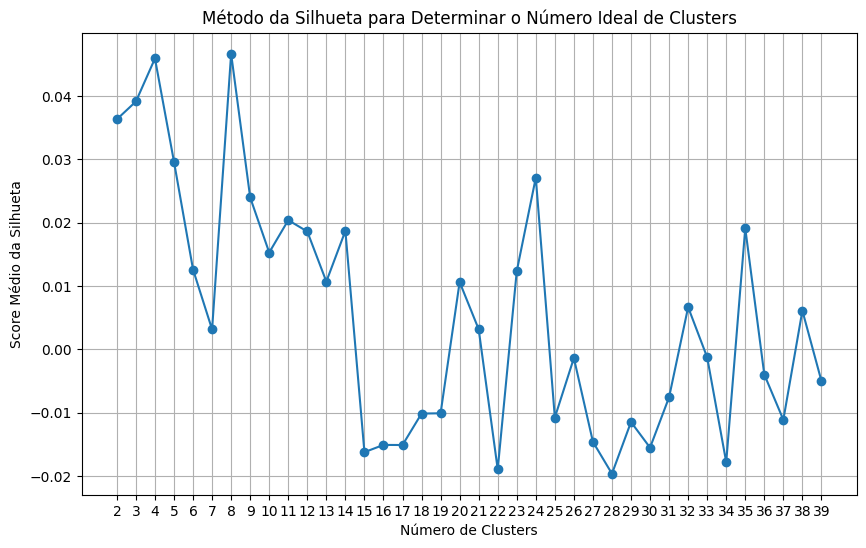

In [ ]:
from sklearn.metrics import silhouette_score

# Definir um intervalo de possíveis números de clusters
range_n_clusters = list(range(2, 40))  # Por exemplo, de 2 a 10 clusters

silhouette_avg_scores = []

for n_clusters in range_n_clusters:
  # Inicializar o modelo KMeans
  kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
  cluster_labels = kmeans.fit_predict(sparse)

  # Calcular o score da silhueta
  silhouette_avg = silhouette_score(sparse, cluster_labels)
  silhouette_avg_scores.append(silhouette_avg)
  print(f"Para n_clusters = {n_clusters}, o score médio da silhueta é: {silhouette_avg}")

# Plotar os scores da silhueta para visualizar
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg_scores, marker='o')
plt.title('Método da Silhueta para Determinar o Número Ideal de Clusters')
plt.xlabel('Número de Clusters')
plt.ylabel('Score Médio da Silhueta')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

# O número ideal de clusters é geralmente onde o score da silhueta é mais alto.
# Você pode inspecionar o gráfico para encontrar esse ponto.

# Testes dos algoritmos de redução de dimensionalidade PCA, UAP e tse-n

Redução de dimensionalidade com PCA aplicada para visualização.


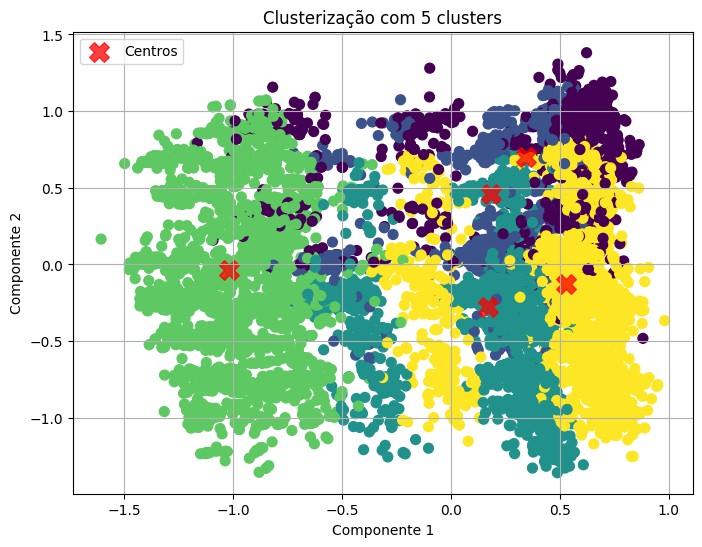

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import numpy as np

def cluster_and_plot(X, n_clusters):
    """
    Aplica KMeans em um dataset e plota um gráfico de dispersão dos clusters.

    Parâmetros:
    - X: matriz de entrada (numpy array ou DataFrame) com n amostras e m atributos.
    - n_clusters: número de clusters desejado.
    """
    # Aplica o KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)

    # Reduz para 2D se necessário (para visualização)
    if X.shape[1] > 2:
        pca = PCA(n_components=2)
        X_vis = pca.fit_transform(X)
        print("Redução de dimensionalidade com PCA aplicada para visualização.")
    else:
        X_vis = X

    # Plotando os clusters
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(X_vis[:, 0], X_vis[:, 1], c=labels, cmap='viridis', s=50)
    centers = kmeans.cluster_centers_

    # Se foi feita redução, também transformamos os centros
    if X.shape[1] > 2:
        centers = pca.transform(centers)

    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centros')
    plt.title(f'Clusterização com {n_clusters} clusters')
    plt.xlabel('Componente 1')
    plt.ylabel('Componente 2')
    plt.legend()
    plt.grid(True)
    plt.show()

cluster_and_plot(sparse, 5)


In [ ]:
df_clustered.head()

,id,title,vote_average,vote_count,release_date,revenue,runtime,budget,original_language,popularity,...,production_countries,cast,director,director_of_photography,writers,producers,music_composer,imdb_rating,imdb_votes,cluster
0,5,Four Rooms,5.862,2688.0,1995-12-09,4257354.0,98.0,4000000.0,en,9.0011,...,United States of America,"David Proval, Salma Hayek Pinault, Paul Calder...","Allison Anders, Alexandre Rockwell, Quentin Ta...","Phil Parmet, Andrzej Sekula, Guillermo Navarro...","Allison Anders, Alexandre Rockwell, Quentin Ta...","Alexandre Rockwell, Quentin Tarantino, Lawrenc...",Combustible Edison,6.7,114105.0,5
1,6,Judgment Night,6.500,349.0,1993-10-15,12136938.0,109.0,21000000.0,en,4.7523,...,United States of America,"Doug Wert, Hank McGill, Christine Harnos, Raic...",Stephen Hopkins,Peter Levy,"Lewis Colick, Jere Cunningham","Gene Levy, Marilyn Vance, Lloyd Segan",Alan Silvestri,6.6,19891.0,19
2,11,Star Wars,8.204,21112.0,1977-05-25,775398007.0,121.0,11000000.0,en,40.6528,...,United States of America,"Ted Burnett, Jerry Walter, James Earl Jones, T...",George Lucas,Gilbert Taylor,George Lucas,"Rick McCallum, George Lucas, Gary Kurtz",John Williams,8.6,1505380.0,19
3,12,Finding Nemo,7.800,19622.0,2003-05-30,940335536.0,100.0,94000000.0,en,16.9242,...,United States of America,"Ellen DeGeneres, Geoffrey Rush, Eric Bana, Geo...",Andrew Stanton,"Jeremy Lasky, Sharon Calahan","Adam Bronstein, Bob Peterson, Jim Capobianco, ...","Graham Walters, John Lasseter",Thomas Newman,8.2,1158587.0,1
4,13,Forrest Gump,8.468,28113.0,1994-06-23,677387716.0,142.0,55000000.0,en,27.4853,...,United States of America,"Margo Moorer, Joe Stefanelli, Ed Davis, Elizab...",Robert Zemeckis,Don Burgess,"Winston Groom, Eric Roth","Wendy Finerman, Steve Tisch, Steve Starkey",Alan Silvestri,8.8,2375129.0,3


Aplicando t-SNE com perplexity=30.0, n_iter=300...


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


t-SNE concluído.
Aplicando KMeans com n_clusters=5...
KMeans concluído.


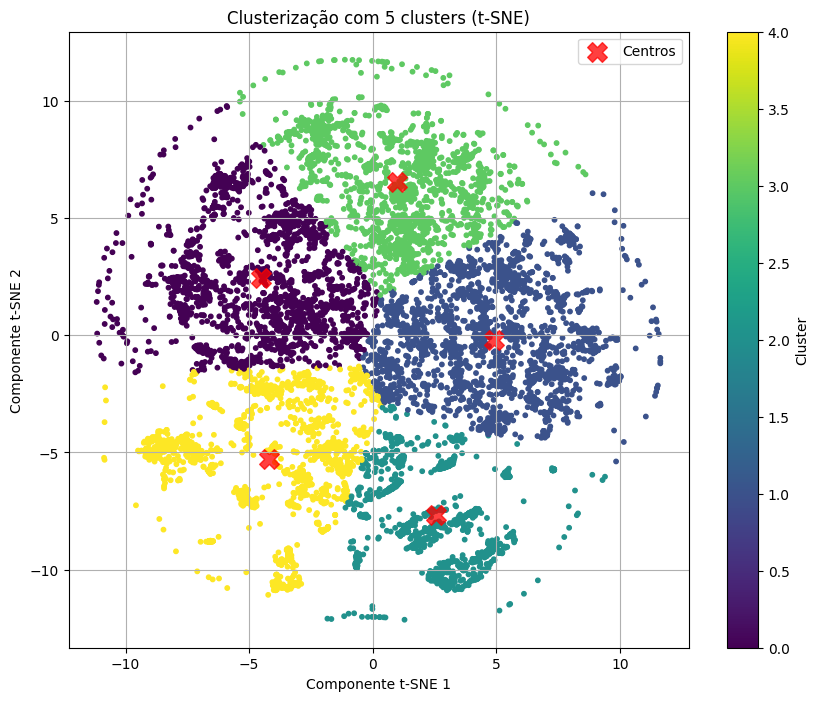

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns # Optional: for potentially nicer plots

def cluster_and_plot_tsne(X, n_clusters, perplexity=30.0, n_iter=300):
    """
    Aplica redução de dimensionalidade com t-SNE, KMeans e plota o resultado.

    Parâmetros:
    - X: matriz de entrada (numpy array ou DataFrame) com n amostras e m atributos.
    - n_clusters: número de clusters desejado.
    - perplexity: parâmetro perplexity para t-SNE.
    - n_iter: número de iterações para t-SNE.
    """
    # Redução de dimensionalidade com t-SNE
    print(f"Aplicando t-SNE com perplexity={perplexity}, n_iter={n_iter}...")
    # Fix: Use init="random" for sparse input
    tsne = TSNE(n_components=2, random_state=42, perplexity=perplexity, n_iter=n_iter, init="random")
    X_tsne = tsne.fit_transform(X)
    print("t-SNE concluído.")

    # Aplica o KMeans nos dados reduzidos
    print(f"Aplicando KMeans com n_clusters={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_tsne)
    print("KMeans concluído.")

    # Plotando os clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='viridis', s=10)
    centers = kmeans.cluster_centers_

    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centros')
    plt.title(f'Clusterização com {n_clusters} clusters (t-SNE)')
    plt.xlabel('Componente t-SNE 1')
    plt.ylabel('Componente t-SNE 2')
    plt.legend()
    plt.grid(True)
    plt.colorbar(scatter, label='Cluster')
    plt.show()

# Exemplo de uso com t-SNE:
# Use a matriz esparsa 'sparse' criada no código anterior
n_clusters_escolhido = 5 # Substitua pelo número de clusters que você determinou
cluster_and_plot_tsne(sparse, n_clusters_escolhido)

# Você pode experimentar com diferentes valores para perplexity e n_iter para t-SNE
# cluster_and_plot_tsne(sparse, n_clusters_escolhido, perplexity=50, n_iter=500)

Aplicando UMAP com n_neighbors=15, min_dist=0.1...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP concluído.
Aplicando KMeans com n_clusters=5...
KMeans concluído.


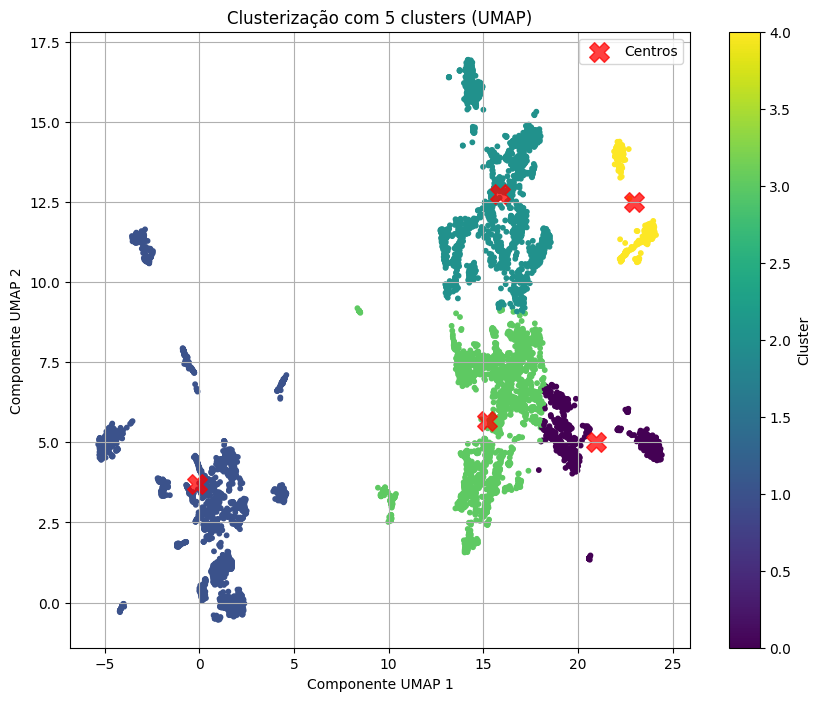

In [ ]:

import umap.umap_ as umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
def cluster_and_plot_umap(X, n_clusters, n_neighbors=15, min_dist=0.1):
    """
    Aplica redução de dimensionalidade com UMAP, KMeans e plota o resultado.

    Parâmetros:
    - X: matriz de entrada (numpy array ou DataFrame) com n amostras e m atributos.
    - n_clusters: número de clusters desejado.
    - n_neighbors: parâmetro n_neighbors para UMAP.
    - min_dist: parâmetro min_dist para UMAP.
    """
    # Redução de dimensionalidade com UMAP
    print(f"Aplicando UMAP com n_neighbors={n_neighbors}, min_dist={min_dist}...")
    reducer = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    X_umap = reducer.fit_transform(X)
    print("UMAP concluído.")

    # Aplica o KMeans nos dados reduzidos
    print(f"Aplicando KMeans com n_clusters={n_clusters}...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_umap)
    print("KMeans concluído.")

    # Plotando os clusters
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], c=labels, cmap='viridis', s=10)
    centers = kmeans.cluster_centers_

    plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X', label='Centros')
    plt.title(f'Clusterização com {n_clusters} clusters (UMAP)')
    plt.xlabel('Componente UMAP 1')
    plt.ylabel('Componente UMAP 2')
    plt.legend()
    plt.grid(True)
    plt.colorbar(scatter, label='Cluster')
    plt.show()
# Exemplo de uso:
# Use a matriz esparsa 'sparse' criada no código anterior
n_clusters_escolhido = 5 # Substitua pelo número de clusters que você determinou
cluster_and_plot_umap(sparse, n_clusters_escolhido)

# Você pode experimentar com diferentes valores para n_neighbors e min_dist para UMAP
# cluster_and_plot_umap(sparse, n_clusters_escolhido, n_neighbors=30, min_dist=0.5)

# Aplicação do Kmeans para incluir a característica "Cluster" ao dataset e criação de imagem


Aplicando UMAP para redução de dimensionalidade...


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensionalidade reduzida para 2 componentes.
Aplicando K-Means com 20 clusters...
K-Means concluído.
Coluna 'cluster' adicionada ao DataFrame.


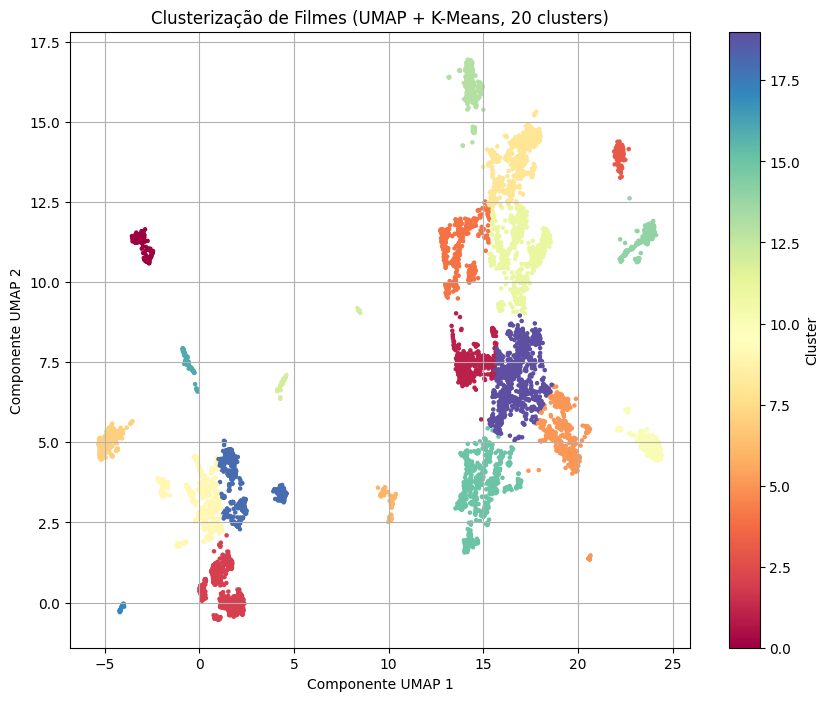


Primeiras linhas do DataFrame com a coluna cluster:
            title  cluster
0      Four Rooms        5
1  Judgment Night       19
2       Star Wars       19
3    Finding Nemo        1
4    Forrest Gump        3

Contagem de filmes por cluster:
cluster
0      237
1      646
2      765
3      336
4      613
5      879
6      183
7      427
8     1021
9      750
10     506
11    1125
12     125
13     564
14     457
15    1174
16     158
17      82
18     606
19    1378
Name: count, dtype: int64


In [ ]:
# prompt: Crie uma função de machine learning para agrupamento usando o algoritmo Kmeans e o umap para redução de dimensionalidade, em seguida crie um atributo cluster parar cada filme da tabela

!pip install umap-learn

import umap
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

def cluster_movies_umap_kmeans(df: pd.DataFrame, data_for_clustering, n_components=2, n_neighbors=15, min_dist=0.1, n_clusters=8):
    """
    Aplica UMAP para redução de dimensionalidade e K-Means para clusterização em dados de filmes,
    e adiciona os rótulos de cluster ao DataFrame original.

    Parâmetros:
    - df: DataFrame original contendo os dados dos filmes.
    - data_for_clustering: Dados (matriz esparsa ou array) a serem usados para clustering.
    - n_components: Número de componentes para redução de dimensionalidade com UMAP (padrão é 2 para visualização).
    - n_neighbors: Número de vizinhos para o UMAP (padrão é 15).
    - min_dist: Distância mínima para o UMAP (padrão é 0.1).
    - n_clusters: Número de clusters para o K-Means (padrão é 5).

    Retorna:
    - df: DataFrame original com uma nova coluna 'cluster' contendo os rótulos de cluster.
    - embedding: A representação reduzida pelo UMAP.
    """
    print("Aplicando UMAP para redução de dimensionalidade...")
    reducer = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
    embedding = reducer.fit_transform(data_for_clustering)
    print(f"Dimensionalidade reduzida para {n_components} componentes.")

    print(f"Aplicando K-Means com {n_clusters} clusters...")
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embedding)
    print("K-Means concluído.")

    # Adicionar os rótulos de cluster ao DataFrame original
    # Garantir que o número de amostras no DataFrame e nos clusters seja o mesmo
    if len(df) == len(clusters):
        df['cluster'] = clusters
        print("Coluna 'cluster' adicionada ao DataFrame.")
    else:
        print("Erro: O número de amostras no DataFrame e nos clusters não corresponde.")
        print(f"DataFrame: {len(df)} amostras, Clusters: {len(clusters)} amostras.")
        df['cluster'] = None # Evita erro caso não correspondam

    # Opcional: Visualizar os clusters se n_components for 2
    if n_components == 2:
        plt.figure(figsize=(10, 8))
        scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters, cmap='Spectral', s=5)
        plt.title(f'Clusterização de Filmes (UMAP + K-Means, {n_clusters} clusters)')
        plt.xlabel('Componente UMAP 1')
        plt.ylabel('Componente UMAP 2')
        plt.colorbar(label='Cluster')
        plt.grid(True)
        plt.show()

    return df, embedding
#exemplo
df_clustered, umap_embedding = cluster_movies_umap_kmeans(df.copy(), sparse, n_clusters=n_clusters_ideal)

print("\nPrimeiras linhas do DataFrame com a coluna cluster:")
print(df_clustered[['title', 'cluster']].head())

print("\nContagem de filmes por cluster:")
print(df_clustered['cluster'].value_counts().sort_index())

In [ ]:
def recomendar_filmes_por_cluster(filme_titulo: str, clustered_df: pd.DataFrame, num_recomendacoes: int = 5) -> list:
    """
    Recebe o título de um filme e retorna uma lista de recomendações de filmes
    que pertencem ao mesmo cluster.

    Parâmetros:
    - filme_titulo: O título do filme para o qual buscar recomendações.
    - clustered_df: O DataFrame pandas que contém os filmes e a coluna 'cluster'.
    - num_recomendacoes: O número de filmes a serem recomendados (padrão é 5).

    Retorna:
    - Uma lista de strings contendo os títulos dos filmes recomendados,
      ou uma mensagem de erro se o filme não for encontrado ou o cluster não for definido.
    """

    filme_info = clustered_df[clustered_df['title'].str.lower() == filme_titulo.lower()]

    if filme_info.empty:
        return [f"Filme '{filme_titulo}' não encontrado no DataFrame."]

    if 'cluster' not in filme_info.columns or filme_info['cluster'].iloc[0] is None:
         return [f"O cluster para o filme '{filme_titulo}' não está definido."]


    cluster_do_filme = filme_info['cluster'].iloc[0]

    filmes_no_mesmo_cluster = clustered_df[
        (clustered_df['cluster'] == cluster_do_filme) &
        (clustered_df['title'].str.lower() != filme_titulo.lower())
    ]

    if filmes_no_mesmo_cluster.empty:
        return [f"Não foram encontrados outros filmes no cluster {cluster_do_filme} do filme '{filme_titulo}'."]

    num_disponiveis = len(filmes_no_mesmo_cluster)
    num_a_recomendar = min(num_recomendacoes, num_disponiveis)

    if num_a_recomendar == 0:
         return [f"Não há filmes suficientes no cluster {cluster_do_filme} para fornecer recomendações."]


    recomendacoes = filmes_no_mesmo_cluster.sample(n=num_a_recomendar)['title'].tolist()

    return recomendacoes



Recomendações para o filme 'Forrest Gump':
- Meet Monica Velour
- Kicked in the Head
- Four Eyed Monsters
- Party Girl
- Same Time, Next Year

Recomendações para o filme 'Venom':
- A Simple Favor
- Thor: The Dark World
- Mad Max Beyond Thunderdome
- Serenity
- New Moon

Recomendações para o filme 'Barbie':
- Finding Dory
- Sgt. Pepper's Lonely Hearts Club Band
- Popeye
- How to Train Your Dragon: The Hidden World
- Hotel Transylvania


In [ ]:
titulo_filme_exemplo = "Forrest Gump"
recomendacoes = recomendar_filmes_por_cluster(titulo_filme_exemplo, df_clustered, num_recomendacoes=5)

print(f"\nRecomendações para o filme '{titulo_filme_exemplo}':")
for rec in recomendacoes:
    print(f"- {rec}")

titulo_filme_exemplo = "Venom"
recomendacoes = recomendar_filmes_por_cluster(titulo_filme_exemplo, df_clustered, num_recomendacoes=5)

print(f"\nRecomendações para o filme '{titulo_filme_exemplo}':")
for rec in recomendacoes:
    print(f"- {rec}")

titulo_filme_exemplo = "Barbie"
recomendacoes = recomendar_filmes_por_cluster(titulo_filme_exemplo, df_clustered, num_recomendacoes=5)

print(f"\nRecomendações para o filme '{titulo_filme_exemplo}':")
for rec in recomendacoes:
    print(f"- {rec}")



Recomendações para o filme 'Forrest Gump':
- Marilyn Hotchkiss' Ballroom Dancing & Charm School
- Charlie Bartlett
- Same Time, Next Year
- Lolita
- Darling Lili

Recomendações para o filme 'Venom':
- Stripes
- Clash of the Titans
- Attack the Block
- The Missing
- The Losers

Recomendações para o filme 'Barbie':
- Over the Hedge
- The Pagemaster
- Storks
- Ooops! Noah Is Gone...
- The Jungle Book 2


Gerando os gráficos Boxplot

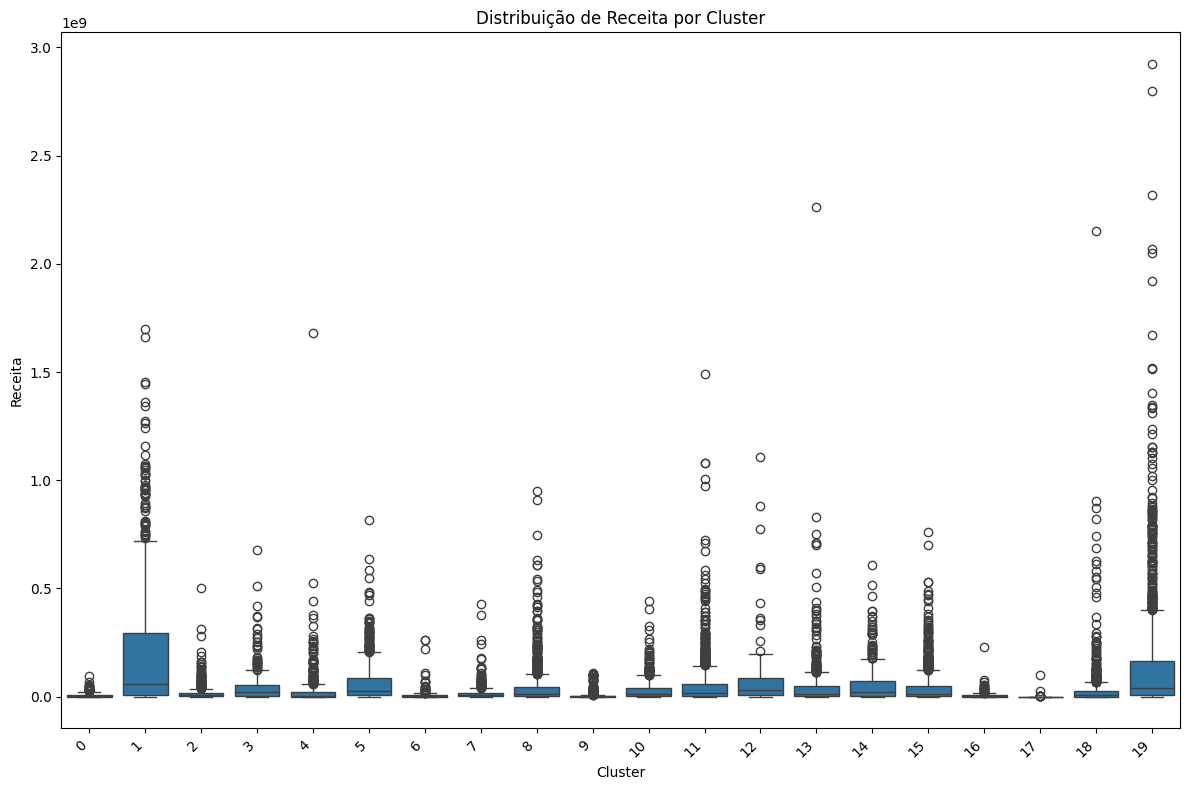

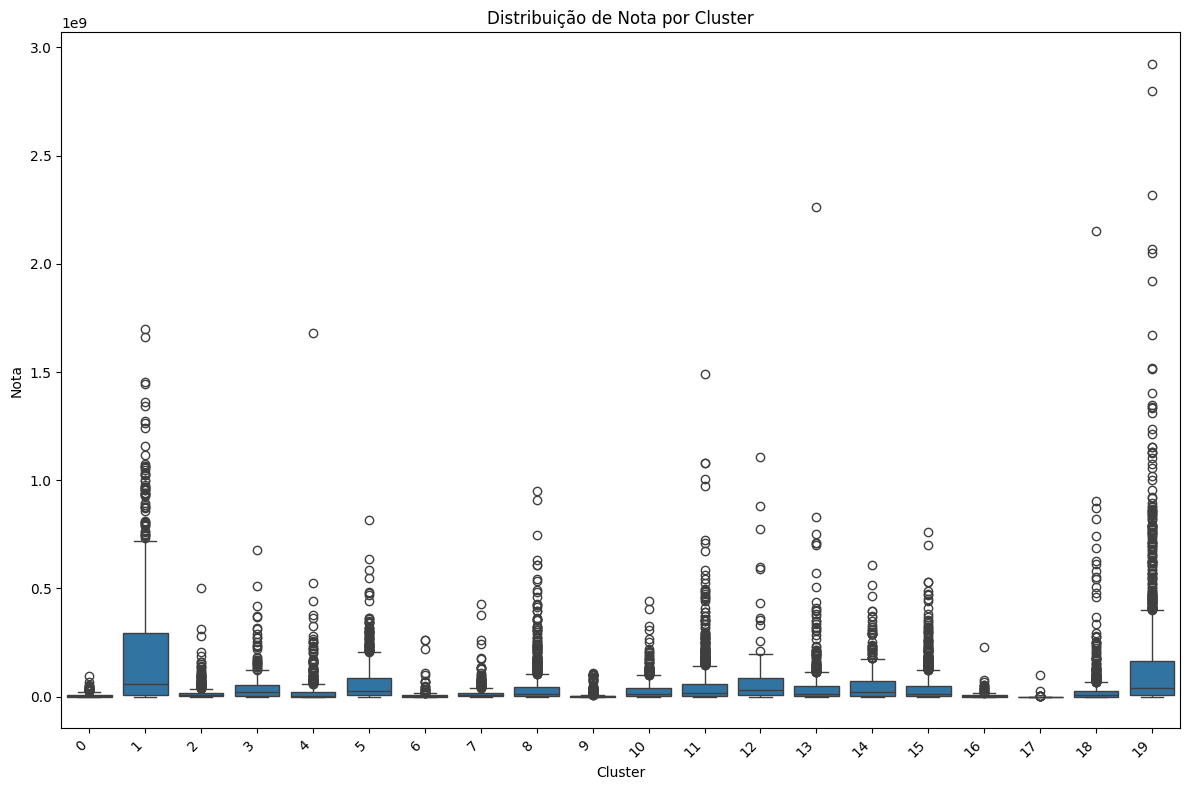

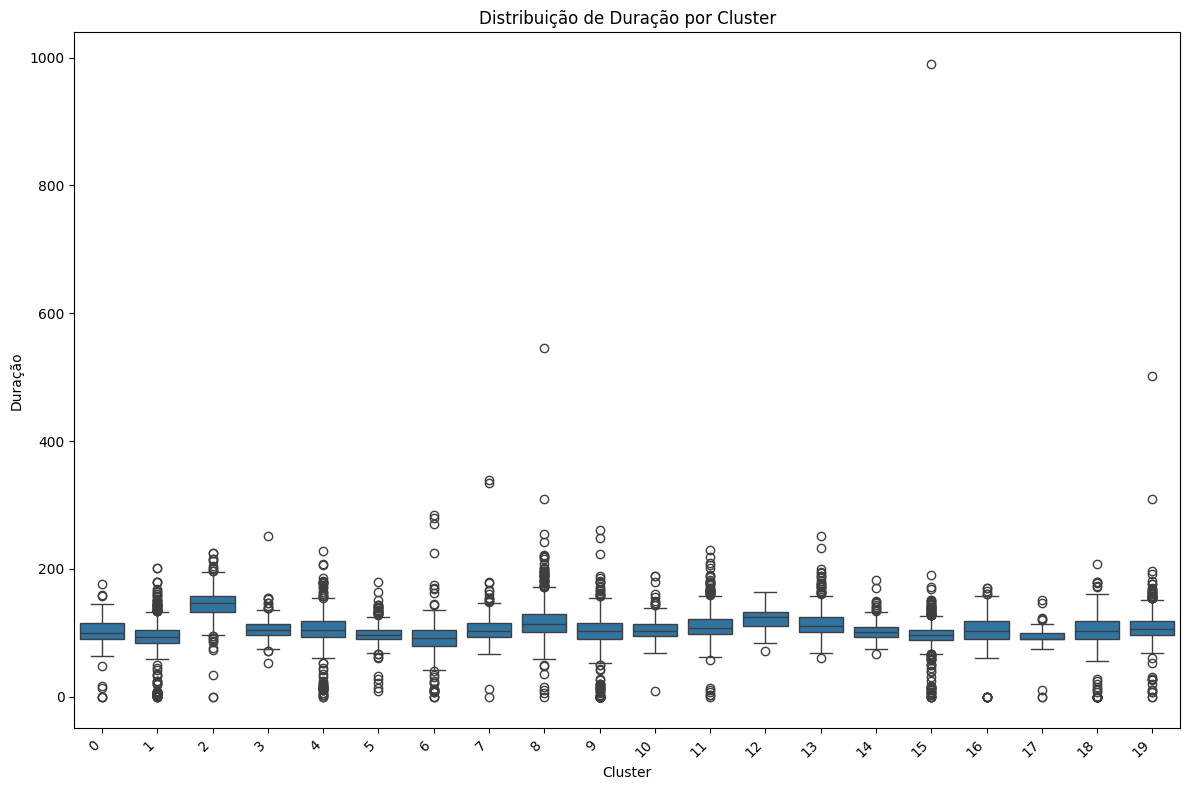

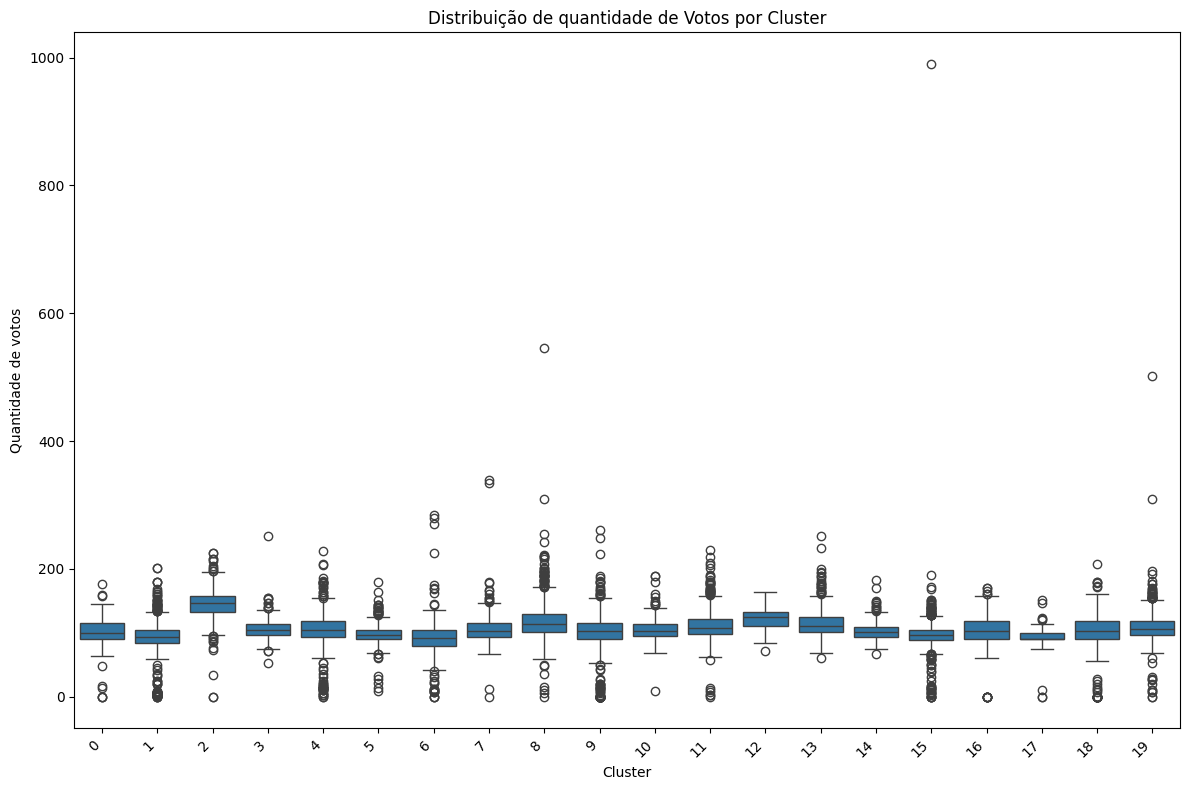

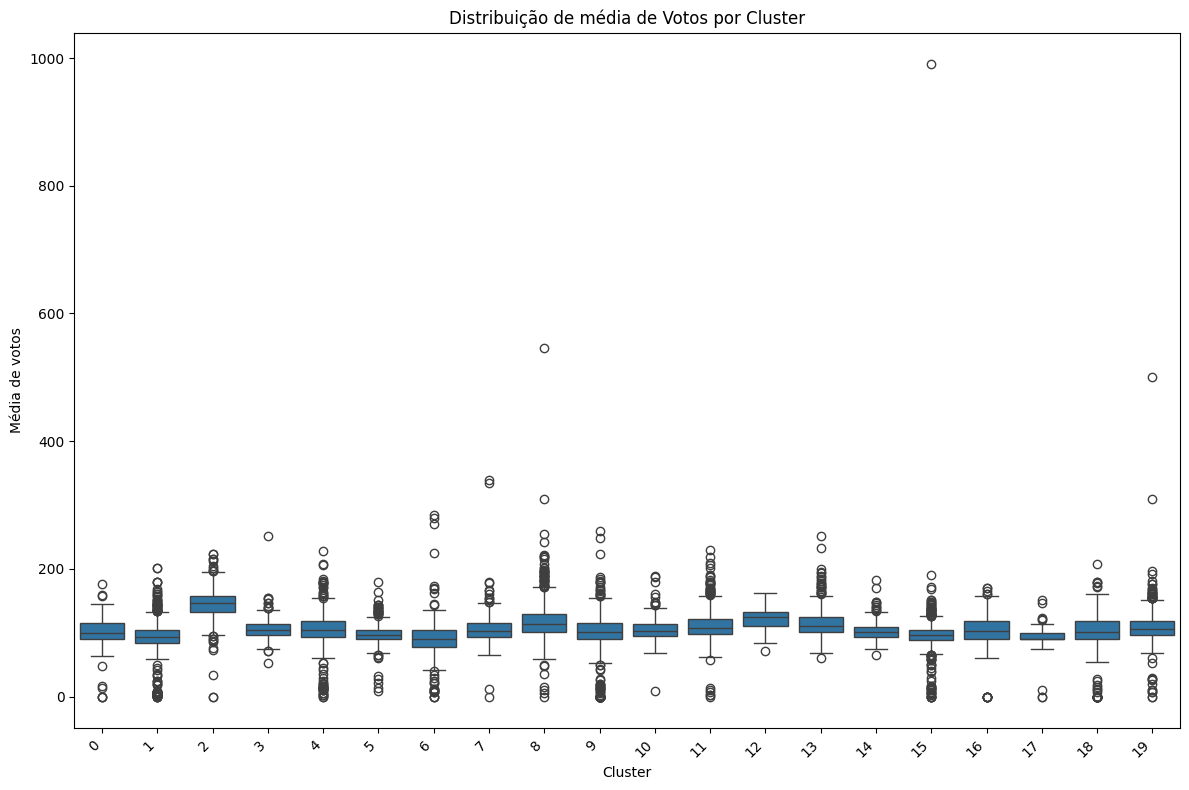

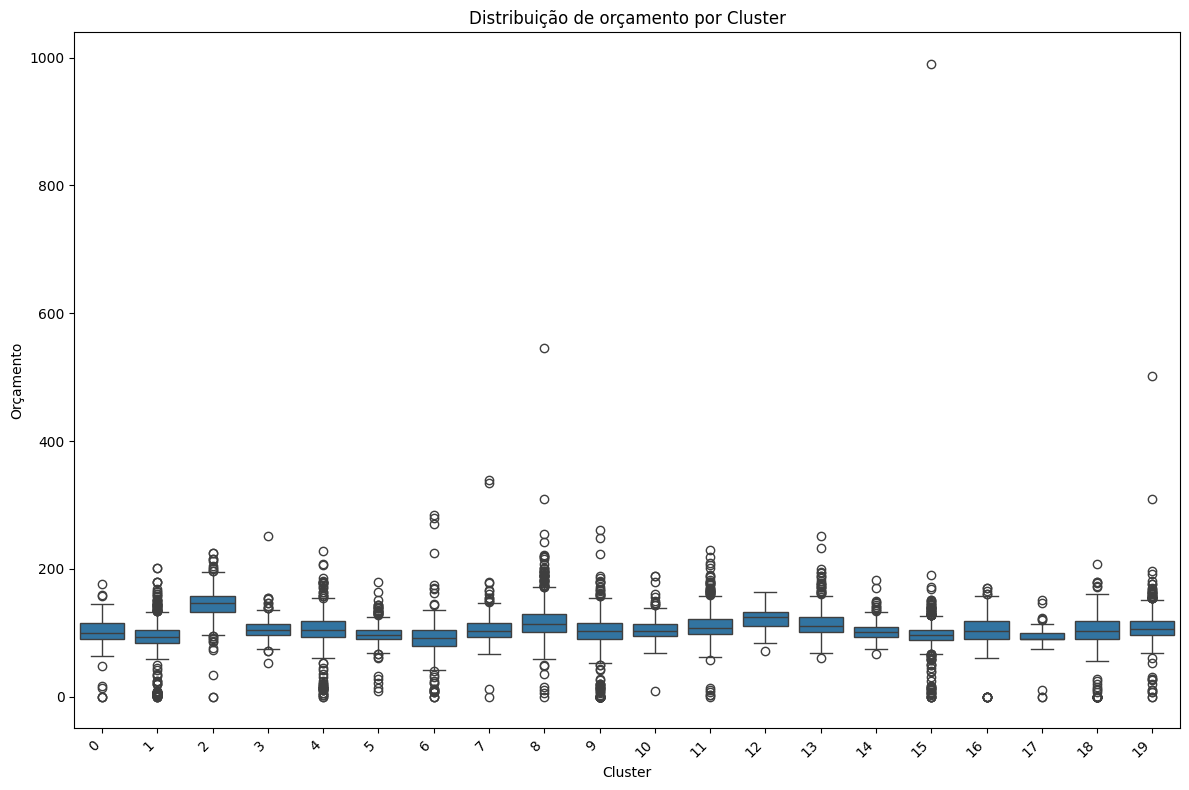

In [ ]:
# prompt: crie uma vizualidação dos clusters com boxplot

# Crie o boxplot dos clusters com base em alguma característica numérica do seu DataFrame original
# Por exemplo, vamos usar a coluna 'revenue' (receita), se ela existir e for numérica
# Substitua 'revenue' pela coluna numérica que você deseja visualizar por cluster

# Verifique se a coluna 'revenue' existe e é numérica
if 'revenue' in df_clustered.columns and pd.api.types.is_numeric_dtype(df_clustered['revenue']):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='cluster', y='revenue', data=df_clustered)
    plt.title('Distribuição de Receita por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Receita')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'revenue' não encontrada ou não é numérica. Escolha outra coluna numérica para o boxplot.")

if 'imdb_rating' in df_clustered.columns and pd.api.types.is_numeric_dtype(df_clustered['imdb_rating']):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='cluster', y='revenue', data=df_clustered)
    plt.title('Distribuição de Nota por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Nota')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'imdb_rating' não encontrada ou não é numérica. Escolha outra coluna numérica para o boxplot.")

if 'runtime' in df_clustered.columns and pd.api.types.is_numeric_dtype(df_clustered['runtime']):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='cluster', y='runtime', data=df_clustered)
    plt.title('Distribuição de Duração por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Duração')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'runtime' também não encontrada ou não é numérica.")

if 'vote_count' in df_clustered.columns and pd.api.types.is_numeric_dtype(df_clustered['vote_count']):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='cluster', y='runtime', data=df_clustered)
    plt.title('Distribuição de quantidade de Votos por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Quantidade de votos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'runtime' também não encontrada ou não é numérica.")

if 'vote_average' in df_clustered.columns and pd.api.types.is_numeric_dtype(df_clustered['vote_average']):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='cluster', y='runtime', data=df_clustered)
    plt.title('Distribuição de média de Votos por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Média de votos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'vote_average' também não encontrada ou não é numérica.")

if 'budget' in df_clustered.columns and pd.api.types.is_numeric_dtype(df_clustered['budget']):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='cluster', y='runtime', data=df_clustered)
    plt.title('Distribuição de orçamento por Cluster')
    plt.xlabel('Cluster')
    plt.ylabel('Orçamento')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("Coluna 'budget' também não encontrada ou não é numérica.")
